## Libraries

In [1329]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn import neighbors, metrics
from sklearn.model_selection import train_test_split

from urllib.request import Request, urlopen
from bs4 import BeautifulSoup

## Import data

Source: <a href="http://tennis-data.co.uk/" target="_blank">http://tennis-data.co.uk/</a>

In [1330]:
df_global=pd.DataFrame()
for i in range(2002,2021):
    
    url="http://tennis-data.co.uk/%d/%d.xlsx" %(i,i)
    df=pd.read_excel(url)
    df_global= pd.concat([df_global,df],ignore_index=True)

Create a datframe with Atp matches since 2002

In [1331]:
print(df_global.shape)
df_global.head()

(50249, 54)


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
0,1,Adelaide,AAPT Championships,2001-12-31,International,Outdoor,Hard,1st Round,3,Arazi H.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Adelaide,AAPT Championships,2001-12-31,International,Outdoor,Hard,1st Round,3,Carlsen K.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Adelaide,AAPT Championships,2001-12-31,International,Outdoor,Hard,1st Round,3,Chela J.I.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Adelaide,AAPT Championships,2001-12-31,International,Outdoor,Hard,1st Round,3,Draper S.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Adelaide,AAPT Championships,2001-12-31,International,Outdoor,Hard,1st Round,3,Enqvist T.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clean Data

We can notice that depending the year, Betting Broker are not the same. So it's better to use the Min/Max and Average of betting odds. 

In [1332]:
#Fill NaN values
df_global['MaxW']=df_global['MaxW'].fillna(round(df_global[['B365W', 'CBW', 'GBW', 'IWW','SBW', 'B&WW', 'EXW', 'PSW', 'UBW', 'LBW', 'SJW']].max(axis=1),2))
df_global['MaxL']=df_global['MaxL'].fillna(round(df_global[['B365L', 'CBL', 'GBL', 'IWL','SBL', 'B&WL', 'EXL', 'PSL', 'UBL', 'LBL', 'SJL']].max(axis=1),2))
df_global['AvgW']=df_global['AvgW'].fillna(round(df_global[['B365W', 'CBW', 'GBW', 'IWW','SBW', 'B&WW', 'EXW', 'PSW', 'UBW', 'LBW', 'SJW']].mean(axis=1),2))
df_global['AvgL']=df_global['AvgL'].fillna(round(df_global[['B365L', 'CBL', 'GBL', 'IWL','SBL', 'B&WL', 'EXL', 'PSL', 'UBL', 'LBL', 'SJL']].mean(axis=1),2))

In [1333]:
# drop useless datas
df_global=df_global[df_global['MaxW'].notna() & df_global['MaxL'].notna()] # select rows where betting odds are present
df_global=df_global.drop(df_global[df_global["Comment"]!="Completed"].index) #keep only completed matches
df_global=df_global.drop(['Comment','Date','ATP'],axis=1) # drop useless columns
df_global=df_global.drop(['B365W', 'CBW', 'GBW', 'IWW','SBW', 'B&WW', 'EXW', 'PSW', 'UBW', 'LBW', 'SJW','B365L', 'CBL', 'GBL', 'IWL','SBL', 'B&WL', 'EXL', 'PSL', 'UBL', 'LBL', 'SJL'],axis=1)
df_global=df_global.drop(['W1','L1','W2','L2','W3','L3','W4','L4','W5','L5','Wsets','Lsets','WPts','LPts'],axis=1)
df_global=df_global.drop(df_global[(df_global["WRank"]=='NR') |  (df_global["LRank"]=='NR')].index) # drop matches with No ranked players
df_global["LRank"] = df_global.LRank.astype(float)# no more 'NR' players so we can convert into float

In [1334]:
#df_global.loc[df_global["Loser"].str.contains("Zayed")==True]


In [1335]:
def checkName(Name):
    if '..' in Name:
        Name=Name.replace('..','.')
    else:
        Name=Name
        
    if '. ' in Name:
        Name=Name.replace('. ','.')
    else:
        Name=Name    
        
    length=len(Name)
    if Name[length-1]!='.':
        Name=Name+'.'
    else:
        Name=Name
    return Name

In [1336]:
#Keep same syntax for player Name in order to have an unique ID for each player
df_global["Winner"]=df_global["Winner"].apply(lambda x: checkName(x))
df_global["Loser"]=df_global["Loser"].apply(lambda x: checkName(x))

In [1337]:
#Check if NaN values left
print(df_global.isna().sum())


Location       0
Tournament     0
Series         0
Court          0
Surface        0
Round          0
Best of        0
Winner         0
Loser          0
WRank         19
LRank         91
MaxW           0
MaxL           0
AvgW           0
AvgL           0
dtype: int64


## Preprocessing data

Columns label encoding

In [1338]:
def Labelizer(column):
    label=sorted(column.unique())
    dictionnary = { val : idx for idx,val in enumerate(label) }
    colLab=column.map(dictionnary)
    return colLab
    

In [1339]:
df_test=df_global.copy()
df_global=df_global.apply(lambda x: Labelizer(x) if x.dtype==object else x,axis=0)

df_global.head()

,Location,Tournament,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,MaxW,MaxL,AvgW,AvgL
0,2,0,3,1,3,0,3,23,615,25.0,46.0,1.60,2.20,1.55,2.17
6,2,0,3,1,3,0,3,323,368,9.0,309.0,1.15,4.25,1.15,4.25
10,2,0,3,1,3,0,3,483,1014,57.0,10.0,3.80,1.36,3.09,1.30
11,2,0,3,1,3,0,3,486,1033,80.0,93.0,1.50,2.55,1.47,2.35
13,2,0,3,1,3,0,3,592,140,104.0,53.0,1.50,2.40,1.50,2.27


In [1340]:
#Rename columns: Winner -> Player1 & Loser -> Player2
df_global.rename(columns={'Winner':'Player1','Loser':'Player2','WRank':'P1Rank','LRank':'P2Rank','MaxW':'MaxP1','MaxL':'MaxP2','AvgW':'AvgP1','AvgL':'AvgP2'}, inplace=True)
#Create the column for the label prediction: Player1 Win
df_global['P1Winner']=1 

In the actual format all winners are Player 1, it will be a problem for the model.
So for random rows, Players 1 and Player 2 datas are switched

In [1341]:
mask=df_global.sample(frac=.5).index
df_global.loc[mask,['Player1','Player2','P1Rank','P2Rank','MaxP1','MaxP2','AvgP1','AvgP2']] = df_global.loc[mask,['Player2','Player1','P2Rank','P1Rank','MaxP2','MaxP1','AvgP2','AvgP1']].values
df_global.loc[mask,['P1Winner']]=0

In [1342]:
df_global.head()

,Location,Tournament,Series,Court,Surface,Round,Best of,Player1,Player2,P1Rank,P2Rank,MaxP1,MaxP2,AvgP1,AvgP2,P1Winner
0,2,0,3,1,3,0,3,615.0,23.0,46.0,25.0,2.20,1.60,2.17,1.55,0
6,2,0,3,1,3,0,3,368.0,323.0,309.0,9.0,4.25,1.15,4.25,1.15,0
10,2,0,3,1,3,0,3,1014.0,483.0,10.0,57.0,1.36,3.80,1.30,3.09,0
11,2,0,3,1,3,0,3,486.0,1033.0,80.0,93.0,1.50,2.55,1.47,2.35,1
13,2,0,3,1,3,0,3,592.0,140.0,104.0,53.0,1.50,2.40,1.50,2.27,1


Create a normalized dataframe

In [1343]:
normalized_df=df_global.copy()
normalized_df.iloc[:,:-1]=df_global.apply(lambda x: (x-x.mean())/x.std() )

normalized_df.head()

,Location,Tournament,Series,Court,Surface,Round,Best of,Player1,Player2,P1Rank,P2Rank,MaxP1,MaxP2,AvgP1,AvgP2,P1Winner
0,-1.857431,-1.684065,0.261823,0.471562,0.862662,-0.718705,-0.484849,0.282800,-1.511925,-0.295120,-0.508854,-0.203865,-0.011840,-0.185122,-0.439232,0
6,-1.857431,-1.684065,0.261823,0.471562,0.862662,-0.718705,-0.484849,-0.467608,-0.608612,2.447302,-0.673539,0.277759,-0.013484,0.691751,-0.604848,0
10,-1.857431,-1.684065,0.261823,0.471562,0.862662,-0.718705,-0.484849,1.494996,-0.126845,-0.670508,-0.179485,-0.401213,-0.003805,-0.551891,0.198388,0
11,-1.857431,-1.684065,0.261823,0.471562,0.862662,-0.718705,-0.484849,-0.109114,1.529228,0.059414,0.191056,-0.368322,-0.008370,-0.480224,-0.108001,1
13,-1.857431,-1.684065,0.261823,0.471562,0.862662,-0.718705,-0.484849,0.212924,-1.159633,0.309673,-0.220656,-0.368322,-0.008918,-0.467576,-0.141124,1


In [1200]:
#correlation matrix
corrMatrix = normalized_df.corr()
print(corrMatrix)

            Location  Tournament    Series     Court   Surface     Round  \
Location    1.000000    0.086961  0.084166 -0.185694  0.062140 -0.017117   
Tournament  0.086961    1.000000  0.103926 -0.011004  0.137828 -0.019093   
Series      0.084166    0.103926  1.000000  0.086332  0.038723 -0.011775   
Court      -0.185694   -0.011004  0.086332  1.000000 -0.162685 -0.057317   
Surface     0.062140    0.137828  0.038723 -0.162685  1.000000  0.006152   
Round      -0.017117   -0.019093 -0.011775 -0.057317  0.006152  1.000000   
Best of     0.107599    0.097297 -0.104166  0.225543  0.040682 -0.086916   
Player1     0.005767   -0.002006  0.010861 -0.012089 -0.007030 -0.013537   
Player2     0.004470   -0.001486  0.013295 -0.001222 -0.001619 -0.014165   
P1Rank     -0.015368   -0.018934 -0.132514  0.016634 -0.038116 -0.197508   
P2Rank     -0.011702   -0.020411 -0.132377  0.025773 -0.031666 -0.195734   
MaxP1      -0.000986    0.006882 -0.000938  0.002949 -0.000580 -0.003654   
MaxP2       

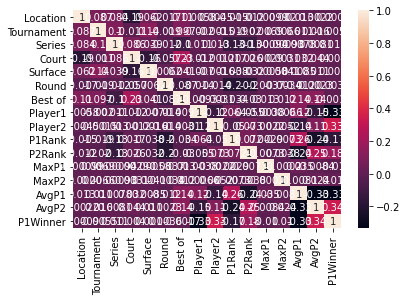

In [1201]:
sn.heatmap(corrMatrix, annot=True)
plt.show() 

## Models

In [1321]:

X=normalized_df.drop(["P1Winner"],axis=1)
y=normalized_df["P1Winner"]

#knn=neighbors.KNeighborsClassifier(n_neighbors=25,weights='uniform')
model = svm.SVC(gamma="auto",kernel='linear')

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2)

model.fit(X_train,y_train)

prediction=model.predict(X_test)

accuracy = metrics.classification_report(y_test,prediction,target_names=['Player1Lost','Player1Won'])

print("prediction",prediction)
print("accuracy: ",accuracy)

prediction [1 0 0 ... 1 0 1]
accuracy:                precision    recall  f1-score   support

 Player1Lost       0.76      0.75      0.76      4780
  Player1Won       0.75      0.76      0.76      4774

    accuracy                           0.76      9554
   macro avg       0.76      0.76      0.76      9554
weighted avg       0.76      0.76      0.76      9554



In [1322]:
from sklearn.metrics import f1_score
f1_score(y_test,prediction)

0.7567115846652042

## Try to improve F1-Score

We will try to improve dataset with new features

### Import players dataset

Source: <a href="https://www.kaggle.com/romanzdk/atp-players-overviews" target="_blank">https://www.kaggle.com/romanzdk/atp-players-overviews/</a>

In [1354]:
df_players=pd.read_csv('player_overviews.csv')
df_players=df_players.drop(df_players.columns[4:17],axis=1)
df_players.head()
df_players.columns=['AtpId','AtpName','FirstName','Name','height','handedness','backhand']
df_players.head()

,AtpId,AtpName,FirstName,Name,height,handedness,backhand
0,a001,sadiq-abdullahi,Sadiq,Abdullahi,0.0,NaN,NaN
1,a005,nelson-aerts,Nelson,Aerts,188.0,NaN,NaN
2,a004,egan-adams,Egan,Adams,178.0,NaN,NaN
3,a006,ronald-agenor,Ronald,Agenor,180.0,NaN,NaN
4,a007,juan-aguilera,Juan,Aguilera,183.0,NaN,NaN


The dataset is not udpated and some current players are missing. The idea is to scrap datas from the https://www.atptour.com/ website.

### Scraping

We scrape datas for the 700 first players of the current ATP ranking 

In [1355]:
#Player informations' are accessible through their atp overview webpage. 
#To get this page we need the name and the id given by the website.
#A first scrap on 'https://www.atptour.com/en/rankings/singles/ gives the url of the overview page
#Then for each player, we scrap First name and Last name in their overview webpage and create a dictionnary

def Scrap():
    AtpIdList=[]
    AtpNameList=[]
    FirstNameList=[]
    LastNameList=[]
    atpRank='https://www.atptour.com/en/rankings/singles/?rankDate=2020-9-14&countryCode=all&rankRange=0-700'
    req = Request(atpRank, headers={'User-Agent': ''})
    webpageAtp = urlopen(req).read()
    soup = BeautifulSoup(webpageAtp, 'html.parser')
    for i in range(0,700):
        url_overview='https://www.atptour.com' + soup.select('.player-cell a')[i]['href']
        AtpName=url_overview.split("/")[5]
        AtpId=url_overview.split("/")[6]
        
        req2 = Request(url_overview, headers={'User-Agent': 'Mozilla/5.0'})
        webpage_overview = urlopen(req2).read()
        soup2 = BeautifulSoup(webpage_overview, 'html.parser')
        try:
            FirstName = soup2.find( attrs={'class': 'first-name'}).get_text()
        except AttributeError:
            FirstName=np.nan
        
        try:
            Name = soup2.find( attrs={'class': 'last-name'}).get_text()
        except AttributeError:
            Name=np.nan
            
        AtpIdList.append(AtpId)
        AtpNameList.append(AtpName)
        FirstNameList.append(FirstName)
        LastNameList.append(Name)
        
        Dictionnary={'AtpId':AtpIdList,'AtpName':AtpNameList,'FirstName':FirstNameList,'Name':LastNameList,'height':np.nan,'handedness':np.nan,'backhand':np.nan}

    return Dictionnary

In [1356]:
df_scrap=Scrap() #get a dictionnary with scraped datas
df_scrap=pd.DataFrame(df_scrap) #convert dictionnary into dataframe
df_total_players=pd.concat([df_players, df_scrap], ignore_index=True) # concat the scraping dataframe with the original one
df_total_players.drop_duplicates(subset ="AtpId",keep = "first", inplace = True) # KEEP UNIQUE VALUES
print(df_total_players.shape)

(11188, 7)


### Change Name syntax to be similar to global_dateset

For a future merge with the betting dataframe, we need to apply the same syntax to the Name column

In [1357]:
def PlayerName(Name,FirstName):
    length= len(Name)
    if "-" in FirstName:
        FirstName=FirstName.split("-")
        player=Name+' '+FirstName[0][0]+'.'+FirstName[1][0]+'.'
    elif " " in FirstName:
        FirstName=FirstName.split()
        if len(FirstName)>1:
            player=Name+' '+FirstName[0][0]+'.'+FirstName[1][0]+'.'
        else:
            player=Name+' '+FirstName[0]+'.'
    elif Name[length-1]=='.':
        player=Name+FirstName[0]+'.'
        
    else:
        player=Name+' '+FirstName[0]+'.'
    return player.title()

In [1358]:
df_total_players['Name']=df_total_players.apply(lambda x: PlayerName(x["Name"],x["FirstName"]), axis=1)
df_total_players=df_total_players.drop(["FirstName"],axis=1) #column not needed anymore
print(df_total_players['Name'].size)
df_total_players.head()

11188


,AtpId,AtpName,Name,height,handedness,backhand
0,a001,sadiq-abdullahi,Abdullahi S.,0.0,NaN,NaN
1,a005,nelson-aerts,Aerts N.,188.0,NaN,NaN
2,a004,egan-adams,Adams E.,178.0,NaN,NaN
3,a006,ronald-agenor,Agenor R.,180.0,NaN,NaN
4,a007,juan-aguilera,Aguilera J.,183.0,NaN,NaN


### Create a dataframe with only players present in the betting dataframe

In [1400]:
df_selected_players=df_total_players.copy()
df_selected_players=df_selected_players[df_selected_players["Name"].isin(df_test['Winner'])| df_selected_players["Name"].isin(df_test['Loser'])] 

In [1548]:
d=players[~players.Name.isin(df_selected_players.Name)]
print(d.shape)
d.head()

(132, 1)


,Name
2269,Kunitcin I.
2937,Hantschek M.
4054,Schuettler P.
4864,MacLagan M.
5363,Ascione A.


132 players datas are still not find

In [1402]:
print(df_selected_players.shape)

(1251, 6)


In [1403]:
print(df_selected_players["height"].isna().sum())
print(df_selected_players["handedness"].isna().sum())
print(df_selected_players["backhand"].isna().sum())

287
591
591


Height, Handedness and Backhand are interesting criterias to analyse but we have too many 'Nan' values. Thanks to the AtId and AtpNAme we can scrap on the website https://www.atptour.com/ 

In [1404]:
def scraping(atpId,atpName,height,handedness,backhand):
    url_atp = 'https://www.atptour.com/en/players/'+atpName+'/'+atpId+'/overview'
    req = Request(url_atp, headers={'User-Agent': 'Mozilla/5.0'})
    webpage = urlopen(req).read()
    soup = BeautifulSoup(webpage, 'html.parser')
    if ((height!=height) or (height==0.0)): #check NaN value or height equals to 0
        try:
            height = soup.find( attrs={'class': 'table-height-cm-wrapper'}).get_text()
            height= height.replace('(','').replace(')','').replace('cm','')
        except AttributeError:
            height=np.nan
    else:
        height=height

    if handedness!=handedness: #check NaN value
        try:
            plays= soup.find_all( attrs={'class':"table-value"})
            if len(plays)>=2:
                plays=plays[2].get_text()
                if len(plays)>1:
                    plays=plays.split(", ")
                    
                    handedness=plays[0].replace("\r","")
                    handedness=handedness.replace("\n","")
                    if backhand != backhand:
                        backhand=plays[1].rstrip()
                    else:
                        backhand=backhand    
                else:
                    if backhand != backhand:
                        backhand=np.nan
                    else:
                        backhand=backhand 
                    handedness=plays[0].replace("\r","")
                    handedness=handedness.replace("\n","")
            else:
                handedness=np.nan
                if backhand != backhand:
                    backhand=np.nan
                else:
                    backhand=backhand
        except AttributeError:
            handedness=np.nan
            backhand=np.nan
    else:
        handedness=handedness
        if backhand != backhand:
            backhand=np.nan
        else:
            backhand=backhand
    if str(height)=='0':
        height=np.nan
    else:
        height=height
    if handedness=='':
        handedness=np.nan
    else:
        handedness=handedness
    
    return height,handedness,backhand

In [1405]:
df_selected_players[['ScrapHeight','ScrapHand','ScrapBack']]=df_selected_players.apply(lambda x : scraping(x['AtpId'],x['AtpName'],x['height'],x['handedness'],x['backhand']),axis=1,result_type="expand")
df_selected_players.head()

,AtpId,AtpName,Name,height,handedness,backhand,ScrapHeight,ScrapHand,ScrapBack
5,a012,marc-albert,Albert M.,0.0,NaN,NaN,NaN,Right-Handed,Unknown Backhand
52,a092,andre-agassi,Agassi A.,180.0,Right-Handed,Two-Handed Backhand,180,Right-Handed,Two-Handed Backhand
53,a0ab,adrian-andreev,Andreev A.,NaN,NaN,NaN,180,Right-Handed,Two-Handed Backhand
75,a162,adam-anderson,Anderson A.,180.0,NaN,NaN,180,Right-Handed,Unknown Backhand
89,a202,wayne-arthurs,Arthurs W.,191.0,NaN,NaN,191,Left-Handed,One-Handed Backhand


In [1406]:
df_selected_players["ScrapHeight"] = df_selected_players.ScrapHeight.astype(float) # convert to float

In [1408]:
print(df_selected_players['height'].isna().sum())
print(df_selected_players['ScrapHeight'].isna().sum())

287
197


In [1409]:
print(df_selected_players['handedness'].isna().sum())
print(df_selected_players['ScrapHand'].isna().sum())
print(df_selected_players['ScrapHand'].value_counts())

591
100
Right-Handed    999
Left-Handed     152
Name: ScrapHand, dtype: int64


In [1410]:

print(df_selected_players['backhand'].isna().sum())
print(df_selected_players['ScrapBack'].isna().sum())
print(df_selected_players['ScrapBack'].value_counts())

591
100
Two-Handed Backhand    595
Unknown Backhand       389
One-Handed Backhand    167
Name: ScrapBack, dtype: int64


We can see that scraping helped a lot, especially for handedness. However, we couldn't use the backhand variable beacause the the value 'Unknown Backhand' means NaN value. So we have too much missing datas for this variable

## Merge

In [1576]:
df_try=df_selected_players.copy()
df_new_features=df_test.copy()
df_new_features=df_new_features.reset_index(drop=True)
df_try=df_try.drop(['AtpId','AtpName','height','handedness','backhand','ScrapBack'],axis=1)
df_try=df_try.reset_index(drop=True)
df_try.head(10)

,Name,ScrapHeight,ScrapHand
0,Albert M.,NaN,Right-Handed
1,Agassi A.,180.0,Right-Handed
2,Andreev A.,180.0,Right-Handed
3,Anderson A.,180.0,Right-Handed
4,Arthurs W.,191.0,Left-Handed
5,Alami K.,185.0,Right-Handed
6,Arazi H.,175.0,Left-Handed
7,Andersen J.F.,191.0,Left-Handed
8,Andersson H.,NaN,Right-Handed
9,Allegro Y.,183.0,Right-Handed


In [1578]:
#Merge betting dataset with players' height and handedness
df_new_features=df_new_features.merge(df_try,left_on='Winner',right_on="Name", how='left',suffixes=['L','W']) #first merge for winner player
df_new_features=df_new_features.merge(df_try,left_on='Loser',right_on="Name", how='left',suffixes=['W','L'])#second merge for loser player

(47878, 15)
(51024, 18)
(54910, 21)


,Location,Tournament,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,...,MaxW,MaxL,AvgW,AvgL,NameW,ScrapHeightW,ScrapHandW,NameL,ScrapHeightL,ScrapHandL
54905,London,Masters Cup,Masters Cup,Indoor,Hard,Round Robin,3,Djokovic N.,Zverev A.,1.0,...,1.35,3.92,1.31,3.52,Djokovic N.,188.0,Right-Handed,Zverev A.,198.0,Right-Handed
54906,London,Masters Cup,Masters Cup,Indoor,Hard,Round Robin,3,Medvedev D.,Schwartzman D.,4.0,...,1.40,4.00,1.29,3.60,Medvedev D.,198.0,Right-Handed,Schwartzman D.,170.0,Right-Handed
54907,London,Masters Cup,Masters Cup,Indoor,Hard,Semifinals,3,Thiem D.,Djokovic N.,3.0,...,2.70,1.66,2.47,1.56,Thiem D.,185.0,Right-Handed,Djokovic N.,188.0,Right-Handed
54908,London,Masters Cup,Masters Cup,Indoor,Hard,Semifinals,3,Medvedev D.,Nadal R.,4.0,...,1.95,2.20,1.80,2.04,Medvedev D.,198.0,Right-Handed,Nadal R.,185.0,Left-Handed
54909,London,Masters Cup,Masters Cup,Indoor,Hard,The Final,3,Medvedev D.,Thiem D.,4.0,...,1.85,2.40,1.66,2.26,Medvedev D.,198.0,Right-Handed,Thiem D.,185.0,Right-Handed


In [1584]:
df_new_features=df_new_features.drop(['NameW','NameL'],axis=1) # columns already present with Winner and Loser
df_new_features=df_new_features.dropna() # delete rows with NaN values
df_new_features=df_new_features.drop_duplicates() #delete duplicated rows
print(df_new_features.shape)

(48010, 19)


,Location,Tournament,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,MaxW,MaxL,AvgW,AvgL,ScrapHeightW,ScrapHandW,ScrapHeightL,ScrapHandL
54905,London,Masters Cup,Masters Cup,Indoor,Hard,Round Robin,3,Djokovic N.,Zverev A.,1.0,7.0,1.35,3.92,1.31,3.52,188.0,Right-Handed,198.0,Right-Handed
54906,London,Masters Cup,Masters Cup,Indoor,Hard,Round Robin,3,Medvedev D.,Schwartzman D.,4.0,9.0,1.40,4.00,1.29,3.60,198.0,Right-Handed,170.0,Right-Handed
54907,London,Masters Cup,Masters Cup,Indoor,Hard,Semifinals,3,Thiem D.,Djokovic N.,3.0,1.0,2.70,1.66,2.47,1.56,185.0,Right-Handed,188.0,Right-Handed
54908,London,Masters Cup,Masters Cup,Indoor,Hard,Semifinals,3,Medvedev D.,Nadal R.,4.0,2.0,1.95,2.20,1.80,2.04,198.0,Right-Handed,185.0,Left-Handed
54909,London,Masters Cup,Masters Cup,Indoor,Hard,The Final,3,Medvedev D.,Thiem D.,4.0,3.0,1.85,2.40,1.66,2.26,198.0,Right-Handed,185.0,Right-Handed


In [1586]:
df_new_features=df_new_features.apply(lambda x: Labelizer(x) if x.dtype==object else x,axis=0) # Columns label encoding

,Location,Tournament,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,MaxW,MaxL,AvgW,AvgL,ScrapHeightW,ScrapHandW,ScrapHeightL,ScrapHandL
0,2,0,3,1,3,0,3,19,495,25.0,46.0,1.60,2.20,1.55,2.17,175.0,0,185.0,1
1,2,0,3,1,3,0,3,287,295,9.0,309.0,1.15,4.25,1.15,4.25,185.0,1,196.0,1
2,2,0,3,1,3,0,3,436,810,57.0,10.0,3.80,1.36,3.09,1.30,198.0,1,185.0,1
3,2,0,3,1,3,0,3,436,810,57.0,10.0,3.80,1.36,3.09,1.30,188.0,1,185.0,1
4,2,0,3,1,3,0,3,439,826,80.0,93.0,1.50,2.55,1.47,2.35,183.0,1,183.0,1


In [1587]:
#Rename columns and randomisation process

df_new_features.rename(columns={'Winner':'Player1','Loser':'Player2','WRank':'P1Rank','LRank':'P2Rank','MaxW':'MaxP1','MaxL':'MaxP2','AvgW':'AvgP1','AvgL':'AvgP2','ScrapHeightW':'HeightP1','ScrapHeightL':'HeightP2','ScrapHandW':'HandP1','ScrapHandL':'HandP2'}, inplace=True)
#Create the column for the label prediction: Player1 Win
df_new_features['P1Winner']=1 
mask=df_new_features.sample(frac=.5).index
df_new_features.loc[mask,['Player1','Player2','P1Rank','P2Rank','MaxP1','MaxP2','AvgP1','AvgP2','HeightP1','HeightP2','HandP1','HandP2']] = df_new_features.loc[mask,['Player2','Player1','P2Rank','P1Rank','MaxP2','MaxP1','AvgP2','AvgP1','HeightP2','HeightP1','HandP2','HandP1']].values
df_new_features.loc[mask,['P1Winner']]=0

In [1588]:
#Normalization process
normalized_df_new_features=df_new_features.copy()
normalized_df_new_features.iloc[:,:-1]=df_new_features.apply(lambda x: (x-x.mean())/x.std() )

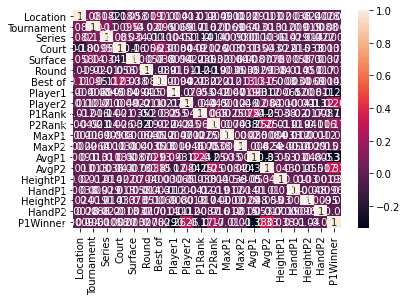

In [1608]:
#Correlation matrix
corrMatrix2=normalized_df_new_features.corr()
sn.heatmap(corrMatrix2, annot=True)
plt.show() 

### Model with news features

In [1609]:
X2=normalized_df_new_features.drop(["P1Winner"],axis=1)
y2=normalized_df_new_features["P1Winner"]

#knn=neighbors.KNeighborsClassifier(n_neighbors=25,weights='uniform')
model = svm.SVC(gamma="auto",kernel='linear')

X_train2,X_test2,y_train2,y_test2 = train_test_split(X2, y2, test_size=0.2)

model.fit(X_train2,y_train2)

prediction2=model.predict(X_test2)

accuracy2 = metrics.classification_report(y_test2,prediction2,target_names=['Player1Lost','Player1Won'])

print("prediction",prediction2)
print("accuracy: ",accuracy2)

prediction [0 1 0 ... 1 0 0]
accuracy:                precision    recall  f1-score   support

 Player1Lost       0.74      0.74      0.74      4808
  Player1Won       0.74      0.74      0.74      4794

    accuracy                           0.74      9602
   macro avg       0.74      0.74      0.74      9602
weighted avg       0.74      0.74      0.74      9602

